In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37477")
client

Client Scheduler: tcp://127.0.0.1:37477 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 50 Memory: 211.24 GB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
# import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
year = 2008
dnf = 2160
itime = 961200+dnf

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50
sstart = 13
send = 34
nremap = 50
dnf = 2160
nchk = 20
nskip = 3

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
# make sure the eigen values are arranged by magnitude 
# (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [6]:
K = xr.open_dataset(op.join(ddir,
                        '5Dave/run%4d/Diff-tensor_5Dave-delta_isig25_%010d_Hann-ker15.nc' 
                            % (year,7886160))
                   ).K.transpose('sig','YC','XC','row','col')
Kt = K.transpose('sig','YC','XC','col','row')
print(K[0,0,500], Kt[0,0,500])
Sym = .5*(K.data + Kt.data)
Sym.shape

<xarray.DataArray 'K' (row: 2, col: 2)>
array([[ 4168.057605,   531.955765],
       [-8399.805753, -4174.989346]])
Coordinates:
    YC       float64 20.0
    XC       float32 313.03275
    sig      float64 26.53
Dimensions without coordinates: row, col <xarray.DataArray 'K' (col: 2, row: 2)>
array([[ 4168.057605, -8399.805753],
       [  531.955765, -4174.989346]])
Coordinates:
    YC       float64 20.0
    XC       float32 313.03275
    sig      float64 26.53
Dimensions without coordinates: col, row


(1, 361, 814, 2, 2)

In [7]:
eigvals, eigvecs = xr.apply_ufunc(eigen, Sym, 
                                  input_core_dims=[['i','j']],
                                  vectorize=True, 
                                  output_core_dims=[['ii'], ['k','ii']]
                                 )
eigvecs.shape

(1, 361, 814, 2, 2)

In [21]:
eval_par = xr.DataArray(eigvals[0,:,:,1], dims=['YC','XC'],
                        coords={'YC':K.YC.data},
                        name='par')
eval_per = xr.DataArray(eigvals[0,:,:,0], dims=['YC','XC'],
                        coords={'YC':K.YC.data},
                        name='per')

In [10]:
maskK = np.ma.masked_invalid(K.isel(sig=0).sel(YC=slice(yNstart+5,yend))[:,:,0,0]).mask

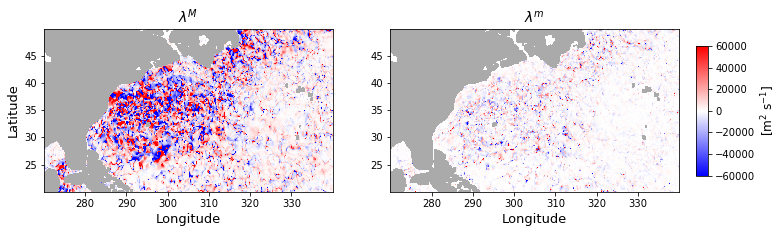

In [24]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

im = ax1.pcolormesh(K.XC.data, K.YC.sel(YC=slice(yNstart+5,yend)).data, 
                    eval_par.sel(YC=slice(yNstart+5,yend)), 
                    vmin=-6e4, vmax=6e4, cmap='bwr', rasterized=True)
ax2.pcolormesh(K.XC.data, K.YC.sel(YC=slice(yNstart+5,yend)).data, 
               eval_per.sel(YC=slice(yNstart+5,yend)), 
               vmin=-6e4, vmax=6e4, cmap='bwr', rasterized=True)

ax1.pcolormesh(K.XC.data, K.YC.sel(YC=slice(yNstart+5,yend)).data, 
               np.ma.masked_array(maskK, ~maskK),
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax2.pcolormesh(K.XC.data, K.YC.sel(YC=slice(yNstart+5,yend)).data, 
               np.ma.masked_array(maskK, ~maskK),
               vmin=0, vmax=3, cmap='binary', rasterized=True)

ax1.set_title(r"$\lambda^M$", fontsize=14)
ax2.set_title(r"$\lambda^m$", fontsize=14)

ax1.set_xlabel(r"Longitude", fontsize=13)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.27) 
cbax = fig.add_axes([0.88, 0.2, 0.014, 0.6])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/Diff-eigens_5Dave-delta_2008-Jan-03.pdf'))

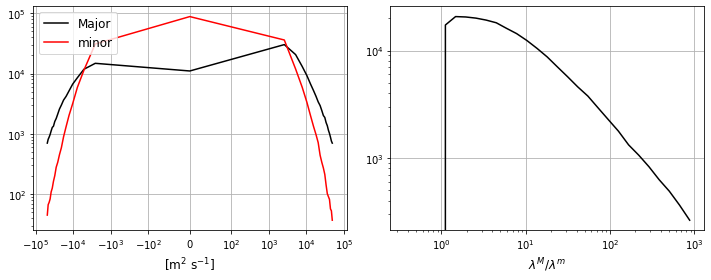

In [20]:
bins = np.linspace(-5e4, 5e4, 40)
par = xhist(eval_par, bins=[bins])
per = xhist(eval_per, bins=[bins])
ratio = xr.DataArray(np.abs(eigvals[0,:,:,1])/np.abs(eigvals[0,:,:,0]), 
                     name='ratio')
aniso = xhist(ratio, bins=[np.logspace(-.5,3,30)])


fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

ax1.plot(par.par_bin, par, 'k', label='Major')
ax1.plot(per.per_bin, per, 'r', label='minor')

ax2.loglog(aniso.ratio_bin, aniso, 'k')

ax1.set_yscale('log')
ax1.set_xscale('symlog', linthreshx=1e2)
ax1.set_xlabel(r"[m$^2$ s$^{-1}$]", fontsize=12)
ax2.set_xlabel(r"$\lambda^M/\lambda^m$", fontsize=12)
ax1.grid(True)
ax2.grid(True)
ax1.legend(loc='upper left', fontsize=12)

In [13]:
print(np.nanmedian(eval_par),np.nanmedian(eval_per))

2363.3591492569703 109.9640420323222


In [14]:
print(np.nanmedian(np.abs(eval_par)),np.nanmedian(np.abs(eval_per)))

8370.745765653472 1694.5803419501829


In [50]:
np.nanmedian(np.log10(ratio))

0.6632464377613058

/tank/users/tuchida/miniconda3/envs/xlayers/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


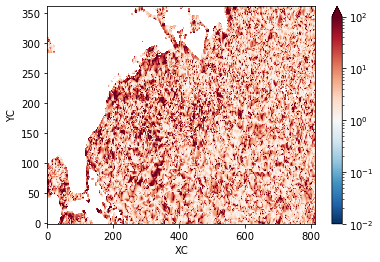

In [15]:
(np.abs(eval_par)/np.abs(eval_per)).plot(norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                                         cmap='RdBu_r')

In [16]:
10**np.nanmedian(np.log10(ratio))

4.369162106549846

In [59]:
np.nanmedian(np.abs(np.ma.masked_invalid(eval_par).compressed()))

12119.291657240185